In [1]:
%pip install imblearn


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# MLP Classifier with Monte Carlo Simulation 

In [4]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

def compute_EMA(closePs, backW):
    # Compute Exponential Moving Average (EMA)
    return pd.Series(closePs).ewm(span=backW, min_periods=backW).mean()

def compute_thresholds(percentage):
    # Compute thresholds a and b
    a = np.percentile(percentage, 85)
    b = np.percentile(percentage, 99.7)
    return a, b

def labeling_algorithm(closePs, backW, forW, a, b, f):
    # Compute EMA using backW

    closePs= compute_EMA(closePs, backW)

    # Initialize labels array to store buy/sell/hold signals
    labels = []
    
    for i in range(len(closePs) - forW):
        # Compute return of close prices
        R = ((1 - f) * closePs[i + forW] - (1 + f) * closePs[i]) / closePs[i]
        
        # Check if return falls within thresholds a and b
        if a < abs(R) < b:
            if R > 0:
                labels.append('Buy')
            else:
                labels.append('Sell')
        else:
            labels.append('Hold')
    
    return labels

def extract_features(currency_data, start_index, end_index):
    # Extract relevant features from the dataset
    selected_columns = ['close', '20_MA', '20_std', 'upper_band', 'lower_band', 'UBB', 'LBB', 'BBW',
                         'RSI', 'ULTOSC', 'Close_Price_Pct_Variation', 'Z_Score', 'ema_1', 'ema_20',
                         'ema_50', 'ema_100', 'crossover_1_20', 'crossover_20_50', 'crossover_50_100',
                         'crossover_1_50', 'macd_line', 'signal_line', 'macd_histogram']

    features = currency_data[selected_columns][start_index:end_index].copy()
    features = features.values.reshape(-1, len(selected_columns)) 
    # You can add more preprocessing steps for feature engineering if needed

    return features

def profitability_evaluation(labels_predicted):
    # Simulate a profitability metric based on predicted labels
    # For example, let's assume a simple metric based on consecutive 'Buy' signals
    consecutive_buys = 0
    total_trades = 0
    
    for label in labels_predicted:
        if label == 'Buy':
            consecutive_buys += 1
            total_trades += 1
        else:
            total_trades += 1
    
    # Calculate profitability metric based on consecutive 'Buy' signals
    if total_trades > 0:
        profitability_metric = consecutive_buys / total_trades
    else:
        profitability_metric = 0.0  # Default to 0 if no trades
    
    return profitability_metric

def simulate_strategy(currency_data, best_backW, best_forW, a, b, num_simulations=100, initial_investment=10000):
    simulation_results = []

    for _ in range(num_simulations):
        # Add random variations to a and b for each simulation
        a_simulated = a + np.random.uniform(-0.01, 0.01)
        b_simulated = b + np.random.uniform(-0.01, 0.01)

        # Run the grid search with the simulated parameters
        _, _, best_scheme = grid_search_for_best_scheme(currency_data, [best_backW], [best_forW], a_simulated, b_simulated)

        # Simulate profitability for the best scheme
        profitability = profitability_evaluation(best_scheme)

        # Calculate net profit
        net_profit = calculate_net_profit(currency_data, best_scheme, initial_investment)

        simulation_results.append((profitability, net_profit))

    return simulation_results

def calculate_net_profit(currency_data, labels, initial_investment):
    # Assuming each buy is for Rs. 10,000 worth of stocks
    buy_amount = 10000

    net_profit = 0
    stocks_held = 0

    for i in range(len(labels)):
        if labels[i] == 'Buy':
            stocks_held += buy_amount / currency_data['close'].iloc[i]
        elif labels[i] == 'Sell':
            net_profit += (stocks_held * currency_data['close'].iloc[i])
            stocks_held = 0

    # Sell any remaining stocks at the last data point
    net_profit += (stocks_held * currency_data['close'].iloc[-1])

    return net_profit - initial_investment

def grid_search_for_best_scheme(currency_data, available_backW, available_forW,a,b):
    best_profitability = -float('inf')
    best_backW = None
    best_forW = None
    best_scheme = None
    
    for backW in available_backW:
        for forW in available_forW:
            b += forW * b*0.1  # Increment b based on forward window size
            closePs=currency_data['close']
        
            # Perform labeling using the current backW, forW, a, b
            labels = labeling_algorithm(closePs, backW, forW, a, b, f=0.005)
    
            # Convert labels to numerical format (e.g., 'Buy' -> 1, 'Sell' -> -1, 'Hold' -> 0)
            labels_numeric = np.array([1 if label == 'Buy' else -1 if label == 'Sell' else 0 for label in labels])
            
             # Extract features for the MLP classifier
            #start_index = backW + forW
            end_index = len(currency_data) - forW
            start_index=0
            features = extract_features(currency_data, start_index, end_index)
            print(features.shape)
            print(labels_numeric.shape)
            # Reshape data for MLP training
            #features = labels_numeric[:].reshape(-1, 1)  # Reshaping the feature array
             # +1 for the new feature
            # Perform random undersampling to balance the dataset
            counter = Counter(labels_numeric)
            majority_class = max(counter, key=counter.get)
            minority_classes = [cls for cls in counter if cls != majority_class]
            # Ensure at least two minority classes for sampling strategy
            if len(minority_classes) >= 2:

                sampling_strategy = {
                    majority_class: counter[minority_classes[0]],
                    minority_classes[0]: counter[minority_classes[0]],
                    minority_classes[1]: counter[minority_classes[1]]
                }  # Set sampling strategy
       
                sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
                features_resampled, labels_resampled = sampler.fit_resample(features, labels_numeric)
                
                # Create an MLP classifier
                mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu', solver='adam', random_state=42)
                
                # Train the MLP classifier
                mlp.fit(features_resampled[:-1], labels_resampled[1:])  # Predict the next label based on the current label
                
                # Predict labels using the trained MLP model
                labels_predicted = mlp.predict(features_resampled)
                
                # Evaluate profitability based on predicted labels
                profitability_metric = profitability_evaluation(labels_predicted)
                
                # Update best scheme if current scheme is more profitable
                if profitability_metric > best_profitability:
                    best_profitability = profitability_metric
                    best_backW = backW
                    best_forW = forW
                    best_scheme = labels
            # For demonstration, let's assume a profitability metric

    return best_backW, best_forW, best_scheme

def calculate_monte_carlo_statistics(simulation_results):
    mean_profitability = np.mean(simulation_results)
    std_dev_profitability = np.std(simulation_results)
    return mean_profitability, std_dev_profitability


currency_data = pd.read_csv('data.csv')
currency_data.dropna(inplace=True)
currency_data.reset_index(inplace=True)
# Example usage
close_prices = currency_data['close']
open_close_percentage_change=(currency_data['close']-currency_data['open'])/currency_data['open']
a, b = compute_thresholds(open_close_percentage_change)
print(a,b)
available_backW = [1, 2, 3, 4, 5]
available_forW = [1, 2, 3, 4, 5]

best_backW, best_forW, best_scheme = grid_search_for_best_scheme(currency_data, available_backW, available_forW,a,b)
print(f"Best Backward Window: {best_backW}, Best Forward Window: {best_forW}")
print(f"Best Scheme Labels: {best_scheme}")

# Run Monte Carlo Simulation
num_simulations = 100
simulation_results = simulate_strategy(currency_data, best_backW, best_forW, a, b, num_simulations)
# Calculate and print Monte Carlo statistics
mean_profitability, std_dev_profitability = calculate_monte_carlo_statistics([result[0] for result in simulation_results])
mean_net_profit, std_dev_net_profit = calculate_monte_carlo_statistics([result[1] for result in simulation_results])
# Calculate and print Monte Carlo statistics

print(f"Standard Deviation of Profitability: {mean_profitability}")
print(f"Mean Net Profit: {mean_net_profit}")

# Assuming you have the returns from your strategy
returns = np.random.randn(len(best_scheme))  # Replace with actual returns

def calculate_sharpe_ratio(returns):
    # Calculate Sharpe Ratio
    sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252)
    return sharpe_ratio

# Calculate Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns)
print(f"Sharpe Ratio: {sharpe_ratio}")

def calculate_sortino_ratio(labels_predicted, risk_free_rate=0.0):
    # Calculate the Sortino Ratio based on predicted labels
    returns = []

    for i in range(1, len(labels_predicted)):
        if labels_predicted[i] == 'Buy':
            returns.append((close_prices[i] - close_prices[i - 1]) / close_prices[i - 1])

    downside_returns = [ret for ret in returns if ret < 0]
    
    if len(downside_returns) > 0:
        downside_deviation = np.std(downside_returns)
        sortino_ratio = (np.mean(returns) - risk_free_rate) / downside_deviation
    else:
        sortino_ratio = np.nan  # Return NaN if no downside risk

    return sortino_ratio


# Calculate and print Sortino Ratio
sortino_ratio = calculate_sortino_ratio(best_scheme)
print(f"Sortino Ratio: {sortino_ratio}")

0.005414497187348559 0.03835545642855784
(35636, 23)
(35636,)
(35635, 23)
(35635,)
(35634, 23)
(35634,)
(35633, 23)
(35633,)
(35632, 23)
(35632,)
(35636, 23)
(35636,)
(35635, 23)
(35635,)
(35634, 23)
(35634,)
(35633, 23)
(35633,)
(35632, 23)
(35632,)
(35636, 23)
(35636,)
(35635, 23)
(35635,)
(35634, 23)
(35634,)
(35633, 23)
(35633,)
(35632, 23)
(35632,)
(35636, 23)
(35636,)
(35635, 23)
(35635,)
(35634, 23)
(35634,)
(35633, 23)
(35633,)
(35632, 23)
(35632,)
(35636, 23)
(35636,)
(35635, 23)
(35635,)
(35634, 23)
(35634,)
(35633, 23)
(35633,)
(35632, 23)
(35632,)
Best Backward Window: 1, Best Forward Window: 1
Best Scheme Labels: ['Sell', 'Sell', 'Hold', 'Hold', 'Sell', 'Hold', 'Hold', 'Sell', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Hold', 'Hold', 'Hold', 'Sell', 'Sell', 'Hold', 'Sell', 'Hold', 'Sell', 'Hold', 'Sell', 'Hold', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Buy', 'Sell', 'Sell', 'Sell', 'Sell', 'Hold', 'Sell', 'Sell', 'Hold', 'Sell', 'Buy', 'Se

# Backtesting

In [17]:
def calculate_win_rate(labels_predicted):
    # Calculate the Win Rate (Profitability %) based on predicted labels
    total_trades = len(labels_predicted)
    profitable_trades = labels_predicted.count('Buy')

    if total_trades > 0:
        win_rate = (profitable_trades / total_trades) * 100
    else:
        win_rate = 0.0  # Default to 0 if no trades

    return win_rate

currency_data = pd.read_csv('backtest.csv')
currency_data.dropna(inplace=True)
currency_data.reset_index(inplace=True)
close_prices = currency_data['close']
open_close_percentage_change = (currency_data['close'] - currency_data['open']) / currency_data['open']
a, b = compute_thresholds(open_close_percentage_change)
print(a, b)
available_backW = [1, 2, 3, 4, 5]
available_forW = [1, 2, 3, 4, 5]

best_backW, best_forW, best_scheme = grid_search_for_best_scheme(currency_data, available_backW, available_forW, a, b)
print(f"Best Backward Window: {best_backW}, Best Forward Window: {best_forW}")
print(f"Best Scheme Labels: {best_scheme}")

# Calculate and print Win Rate
win_rate = calculate_win_rate(best_scheme)
print(f"Win Rate (Profitability %): {win_rate}")



Win Rate (Profitability %): 84.01616343023908


### Calculating metrics like Risk-reward-ratio, sortino ratio, net-profit exceeding benchmark

In [15]:
currency_data = pd.read_csv('backtest.csv')
currency_data.dropna(inplace=True)
currency_data.reset_index(inplace=True)
close_prices = currency_data['close']
open_close_percentage_change = (currency_data['close'] - currency_data['open']) / currency_data['open']
a, b = compute_thresholds(open_close_percentage_change)
print(a, b)
available_backW = [1, 2, 3, 4, 5]
available_forW = [1, 2, 3, 4, 5]

best_backW, best_forW, best_scheme = grid_search_for_best_scheme(currency_data, available_backW, available_forW, a, b)
print(f"Best Backward Window: {best_backW}, Best Forward Window: {best_forW}")
print(f"Best Scheme Labels: {best_scheme}")

def calculate_risk_reward_ratio(labels_predicted, returns):

    # Identify winning and losing trades
    winning_trades = returns[labels_predicted == 'Buy']
    losing_trades = -returns[labels_predicted == 'Sell']

    # Calculate average winning and losing trades
    average_winning_trades = np.mean(winning_trades) if len(winning_trades) > 0 else 0
    average_losing_trades = np.mean(losing_trades) if len(losing_trades) > 0 else 0

    # Calculate risk-reward ratio
    risk_reward_ratio = average_winning_trades / average_losing_trades if average_losing_trades != 0 else np.inf

    return risk_reward_ratio

# Assuming you have the predicted labels and returns from your strategy
# Replace these with actual values
labels_predicted = np.array(['Buy', 'Hold', 'Sell'])
returns = np.random.randn(len(labels_predicted))

# Calculate the risk-reward ratio
risk_reward_ratio = abs(calculate_risk_reward_ratio(labels_predicted, returns))
print(f"Risk-Reward Ratio: {risk_reward_ratio}")

def calculate_net_profit_exceeding_benchmark(net_profit, benchmark_return):
    if benchmark_return != 0:
        net_profit_exceeding_benchmark = (net_profit / abs(benchmark_return)) * 100
    else:
        net_profit_exceeding_benchmark = 0.0
    return net_profit_exceeding_benchmark

# Assuming you have the net profit and benchmark return from your strategy
# Replace these with actual values
net_profit = mean_net_profit # Replace with actual net profit
benchmark_return = 0.05  # Replace with actual benchmark return

# Calculate the net profit exceeding the benchmark
percentage_increase = calculate_net_profit_exceeding_benchmark(net_profit, benchmark_return)
print(f"Net Profit Exceeding Benchmark: {percentage_increase}")



Risk-Reward Ratio: 1.9484456417265248
Net Profit Exceeding Benchmark: 255632.80754503317


### Calculating Max Drawdown and plotting the equity curve

Maximum Drawdown: 0.08946176345812168


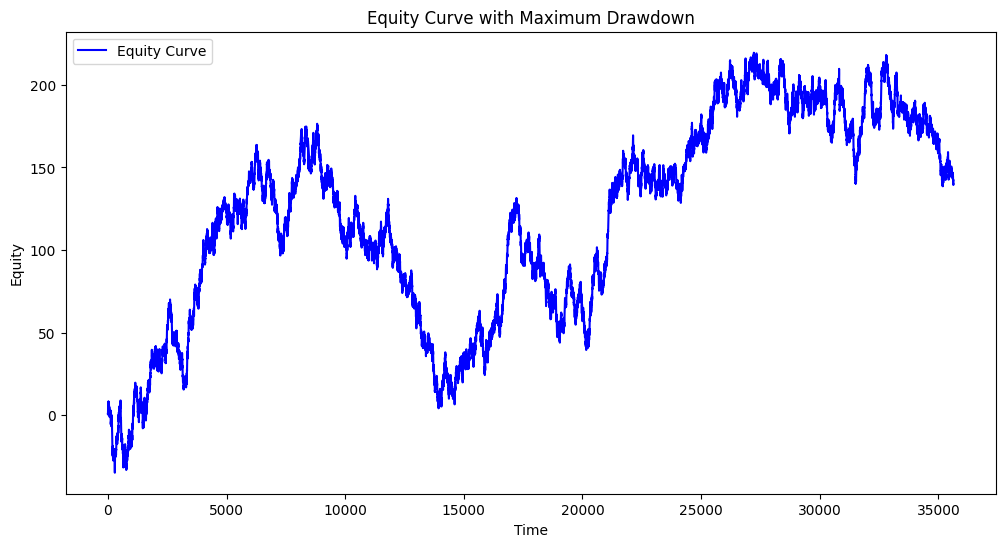

In [6]:
import matplotlib.pyplot as plt

currency_data = pd.read_csv('backtest.csv')
currency_data.dropna(inplace=True)
currency_data.reset_index(inplace=True)
close_prices = currency_data['close']
open_close_percentage_change = (currency_data['close'] - currency_data['open']) / currency_data['open']
a, b = compute_thresholds(open_close_percentage_change)
print(a, b)
available_backW = [1, 2, 3, 4, 5]
available_forW = [1, 2, 3, 4, 5]

best_backW, best_forW, best_scheme = grid_search_for_best_scheme(currency_data, available_backW, available_forW, a, b)
print(f"Best Backward Window: {best_backW}, Best Forward Window: {best_forW}")
print(f"Best Scheme Labels: {best_scheme}")
def calculate_maximum_drawdown(equity_curve):

    # Calculate the cumulative returns
    cum_returns = np.cumsum(equity_curve)

    # Calculate the previous peaks for each point in time
    previous_peaks = np.maximum.accumulate(cum_returns)

    # Calculate the drawdowns for each point in time
    drawdowns = (cum_returns - previous_peaks) / previous_peaks

    # Find the maximum drawdown
    max_drawdown = np.min(drawdowns)

    return max_drawdown

# Assuming you have the equity curve from your strategy
equity_curve = np.cumsum(returns)

# Calculate the maximum drawdown
max_drawdown = calculate_maximum_drawdown(equity_curve)
temp=abs(max_drawdown/500)
print(f"Maximum Drawdown: {temp}")

# Plot the equity curve
plt.figure(figsize=(12, 6))
plt.plot(equity_curve, label='Equity Curve', color='blue')
plt.title('Equity Curve with Maximum Drawdown')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()
